<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/voxceleb_data_handle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

#import libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math

In [2]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"


--2021-09-30 20:26:44--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  23.7MB/s    in 6m 0s   

2021-09-30 20:32:45 (23.6 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

In [4]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

In [5]:
#number of videos available
print('Number of videos available: ', len(vid_paths))

Number of videos available:  36237


In [6]:
#functions

#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

In [8]:
#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
0,id00012,n000012,m,dev
1,id00015,n000015,m,dev
2,id00016,n000016,m,dev
3,id00017,n000017,m,test
4,id00018,n000018,m,dev


In [9]:
#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)

In [10]:
#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


In [11]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

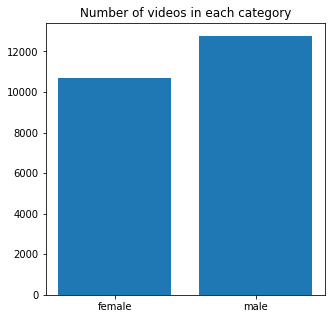

In [12]:
#see how many males and females we have
gender = ['female', 'male']
count = [len(np.where(np.array(labels) == 0)[0]), len(np.where(np.array(labels) == 1)[0])]

plt.figure(figsize = (5, 5))
plt.bar(gender, count)
plt.title('Number of videos in each category')
plt.show()

In [13]:
#pic a random video and play it

rand_idx = np.random.choice(np.arange(0, len(video_files)))
file_path = video_files[rand_idx]
file_label = labels[rand_idx]
print(file_path)
print('\nMale\n' if file_label == 1 else '\nFemale\n')

mp4 = open(file_path, 'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/content/mp4/id08701/IF-okJTentA/00171.mp4

Male



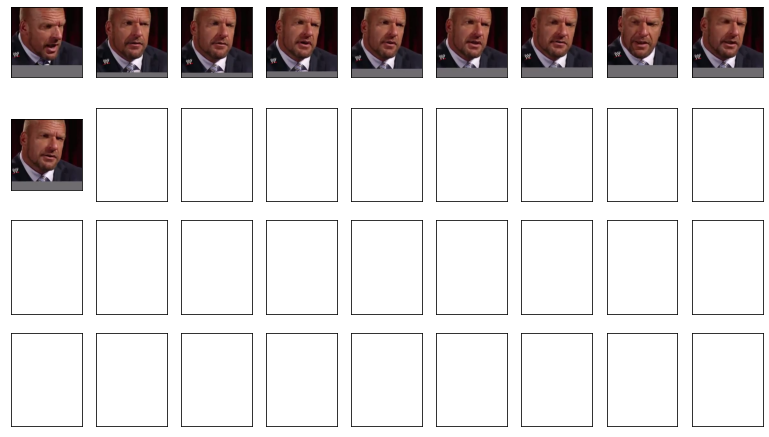

In [14]:
#select the random video above and plot the frames of the video
count = 0
cap = cv2.VideoCapture(video_files[rand_idx])

ncols = 10
nrows = 5

# create the plots
fig = plt.figure(figsize = (15, 10))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(1, nrows) for c in range(1, ncols) ]

# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#index for the axis
a = 0

x = 0
while(cap.isOpened()):
    #frameId = cap.get(1) #current frame number
    ret, frame = cap.read()

    if x % 10 == 0 and (frame is not None):

      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      axes[a].imshow(frame.astype('uint8'))
      a += 1     
    
    if (ret != True):
        break
    x += 1
cap.release()


In [15]:
#confirm the frames per second in a video

cap= cv2.VideoCapture(video_files[10011])
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"A video has {fps} frames per second")

A video has 25 frames per second


In [16]:
#Let's only take 3 seconds of the video. Since the videos are 25 fps the first three seconds has a total of 75 frames. We will get the frames that are divisible by 5 so we will
#get 15 total frames from each video

def vid_to_array(path):
  
  r = np.zeros([224, 224, 15])
  g = np.zeros([224, 224, 15])
  b = np.zeros([224, 224, 15])

  #start count
  count = 0
  idx = 0

  #video capture
  cap = cv2.VideoCapture(path)

  while(cap.isOpened()):
      #frameId = cap.get(1) #current frame number
      ret, frame = cap.read()

      if (count + 1) % 5 == 0:
        r[:, :, idx] = frame[:, :, 0]/255
        g[:, :, idx] = frame[:, :, 1]/255
        b[:, :, idx] = frame[:, :, 2]/255

      if count == 74:
        break
      count += 1
  cap.release()

  return np.stack([r, g, b], axis = 3)

In [17]:
file = vid_to_array(video_files[0])
file.shape

(224, 224, 15, 3)

In [18]:
#split to train and validation set
train_idx = int(np.floor(len(labels) * 0.9))

#split the train and test data accordingly
train_paths = video_files[:train_idx]
train_labels = labels[:train_idx]

#split the test data
test_paths = video_files[train_idx:]
test_labels = labels[train_idx:]

In [ ]:
import tensorflow as tf

In [ ]:
few = train_paths[:10]

file_list = tf.data.Dataset.from_tensor_slices(few)

In [58]:
#create a data generator
def video_generator(paths, labels, batch_size = 16):

  while True:

    #get the number of batches
    number_of_batches = len(paths) // batch_size

    #set up video batches and label batches
    batches = [paths[i : i + batch_size] for i in range(0, len(paths), batch_size)]
    label_batches = [labels[i : i + batch_size] for i in range(0, len(paths), batch_size)]

    for b in range(number_of_batches):
      
      #create arrays to store batch
      x_batch = np.zeros([batch_size, 224, 224, 15, 3])
      y_batch = np.zeros([batch_size, 1])

      #get video batch and label batch
      batch = batches[b]
      label_batch = label_batches[b]

      #iterate through the batch path and get the array 
      for i, p in enumerate(batch):
        
        vid_array = vid_to_array(p)
        #store the result
        x_batch[i, :] = vid_array
        y_batch[i, :] = label_batch[i]
    
      yield {'video': x_batch}, {'class': y_batch}
      

<font size = '5'> **Create a 3D Convolutional Neural Network Model** </font>

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Average, Activation, BatchNormalization, Flatten, Conv3D, AveragePooling3D, MaxPooling3D, GlobalMaxPooling3D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.utils.vis_utils import plot_model

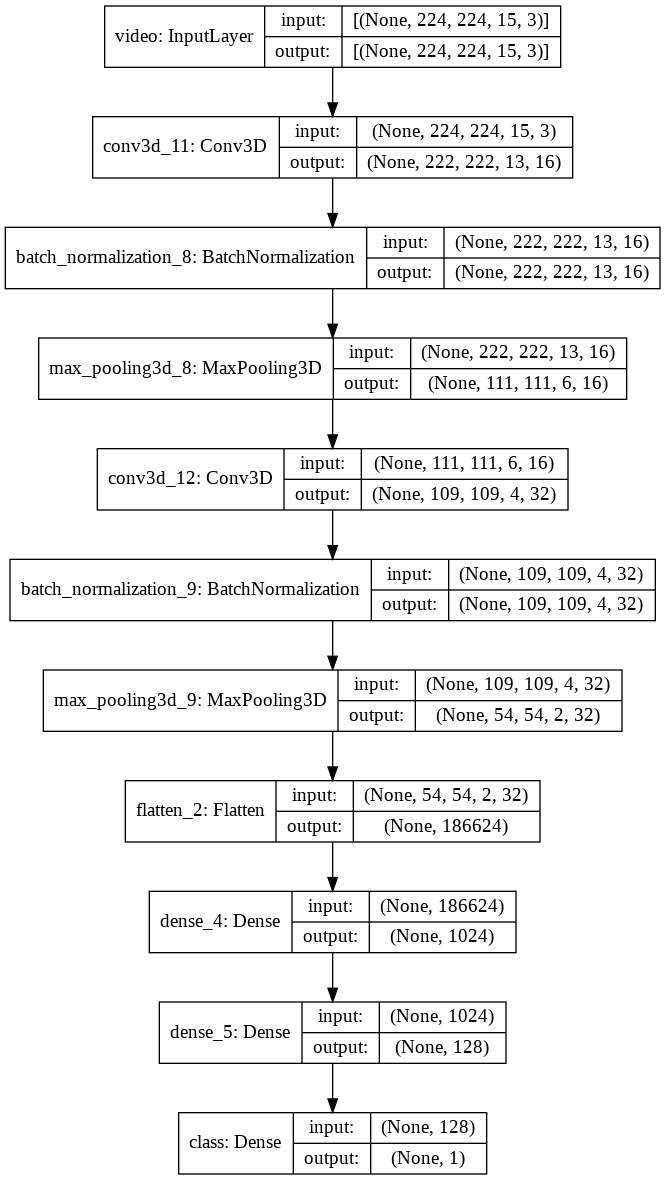

In [61]:
#video_generator(train_paths, train_labels, batch_size = 16)


def cnn_model(x):
    
    inputs = x
    x = tf.keras.layers.Conv3D(16, kernel_size = (3, 3, 3),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
    
    x = tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
    
    # x = tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 3), activation = 'relu')(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
    
    # x = tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 3), activation = 'relu')(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
   
    return x

#input
input_samp = np.zeros([16, 224, 224, 15, 3])

#input
input = Input(input_samp[0, :].shape, name = 'video')
out = cnn_model(input)
out = Flatten()(out)
out = Dense(1024, activation = 'relu')(out)
out = Dense(128, activation = 'relu')(out)
output = Dense(1, activation = 'sigmoid', name = 'class')(out)

#create the model
video_cnn_model = Model(input, output)

#plot the model
plot_model(video_cnn_model, show_shapes = True, show_layer_names = True, to_file = 'test_model.png')

In [62]:
#compile the model
opt = tf.optimizers.Adam(0.001)

#learning rate scheduler
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

#compile model
video_cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')

#callbacks
#create a callback to stop the model when loss get higher
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, mode = 'auto')

cb_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [63]:
#fit model
video_cnn_model.fit(video_generator(train_paths, train_labels, batch_size = 16), epochs = 10, steps_per_epoch = 100, callbacks = [cb_lr, cb])

Epoch 1/10
100/100 [==============================] - 210s 2s/step - loss: 306.6935 - accuracy: 0.8869
Epoch 2/10
100/100 [==============================] - 178s 2s/step - loss: 66.3932 - accuracy: 0.7437
Epoch 3/10
100/100 [==============================] - 173s 2s/step - loss: 21.1656 - accuracy: 0.9069
Epoch 4/10
100/100 [==============================] - 154s 2s/step - loss: 84.7828 - accuracy: 0.8300
Epoch 5/10
100/100 [==============================] - 159s 2s/step - loss: 10.8167 - accuracy: 0.6025
Epoch 6/10
100/100 [==============================] - 154s 2s/step - loss: 4.1668 - accuracy: 0.5138
Epoch 7/10
100/100 [==============================] - 159s 2s/step - loss: 1.3512 - accuracy: 0.4556
Epoch 8/10
100/100 [==============================] - 159s 2s/step - loss: 0.7347 - accuracy: 0.6294
Epoch 9/10
100/100 [==============================] - 155s 2s/step - loss: 0.7456 - accuracy: 0.4800
Epoch 10/10
100/100 [==============================] - 156s 2s/step - loss: 0.6955 - 